In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/cubicasa5k.zip" -d "/content/cubicasa_dataset"

Streaming output truncated to the last 5000 lines.
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/F1_scaled.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/F1_original.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/4014/model.svg  
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/F1_scaled.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/F1_original.png  
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14296/model.svg  
   creating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14295/
  inflating: /content/cubicasa_dataset/cubicasa5k/high_quality_architectural/14295/F2_scaled.png  
  inflating:

In [5]:
!pip install opencv-python matplotlib lxml tqdm pycocotools


In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [7]:
!pip install torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [8]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-v8bhibyl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-v8bhibyl
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352513 sha256=8fbf26b8ecc404e690f8f15ebe538b514ddb8ed62da48907d1da9c45e56532b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6gcvvgu/wheels/d3/6e/bd/1969578f1456a6be2

In [9]:
import os
import json
from bs4 import BeautifulSoup

import re

translation = {
    "OH": "Living Room",
    "MH": "Bedroom",
    "K": "Kitchen",
    "ET": "Entry",
    "KH": "Bathroom",
    "WC": "Toilet",
    "VH": "Walk-in Closet",
    "TK": "Utility Room",
    "KHH": "Utility Room",
    "PKH": "Dressing Room",
    "KHH/PKH": "Utility / Dressing Room",
    "PH": "Washing Room",
    "RT": "Dining Area",
    "TERASSI": "Terrace",
    "KUISTI": "Porch",
    "TEKN": "Technical Room",
    "TEKN.TILA": "Technical Room",
    "VARASTO": "Storage",
    "VAR": "Storage",
    "VAR/": "Storage",
    "SAUNA": "Sauna",
    "S": "Sauna",
    "AULA": "Lobby",
    "AH": "Living Room/Lounge",
    "TYÖHUONE": "Office",
    "TYÖH/VERSTAT": "Office/Workshop",
    "TYÖ- JA VIERASH": "Office and Guest Room",
    "RUOKAILU": "Dining Area",
    "RUOK": "Dining",
    "RUOK.TILA": "Dining Area",
    "PARVEKE": "Balcony",
    "LASI-PARV": "Glazed Balcony",
    "LASITETTU": "Glazed Balcony/Terrace",
    "LASIKUISTI": "Glazed Porch",
    "ULKOTILA": "Outdoor Space",
    "KORKEA TILA": "High Ceiling Space",
    "KATT.H": "Ceiling Height Room",
    "H": "Generic Room",
    "R": "Generic Room",
    "UNDEFINED": "Unlabeled",
    "PE": "Mirror/Cabinet",
    "PESUH": "Laundry Room",
    "PESU": "Laundry/Washing Room",
    "PSH": "Shower",
    "KK": "Kitchenette",
    "KATOS": "Shelter/Shed",
    "SH": "Shower Room",
    "KEITTIÖ": "Kitchen",
    "AUTOKATOS": "Carport",
    "AUTOTALLI": "Garage",
    "AT": "Garage",
    "LIIKETILA": "Commercial Space",
    "ALKOVI": "Alcove",
    "SpaceForAppliance": "Appliance Space",
    "SpaceForAppliance2": "Appliance Space",
    "APUK": "Auxiliary Kitchen",
    "HARRASTUS": "Hobby Room",
    "HARRASTETILA": "Hobby Space",
    "TH": "Fireplace/Technical Room",
    "RP": "Fireplace",
    "KÄYTÄVÄ": "Corridor",
    "WC/KH": "Toilet/Bathroom",
    "WC/PH": "Toilet/Washing Room",
    "WC-PH": "Toilet-Washing Room",
    "KH/KHH": "Bathroom/Utility Room",
    "KOM": "Closet/Storage",
    "ULLAKKO": "Attic",
    "KYLMÄ VARASTOTILA": "Cold Storage",
    "KYLMÄ VAR.": "Cold Storage",
    "AVOK": "Open Kitchen", # Added missing comma here
    "PUUPATIO": "Wooden Patio",
    "NURMI PIHAA": "Grass Yard",
    "PSH": "Shower",
    "LÖYLYH": "Steam Room",
    "MEIKKIH": "Makeup Room",
    "KOTITEATTERI": "Home Theater",
    "SISÄVAR": "Indoor Storage",
    "ULKOVAR": "Outdoor Storage",
    "ÖLJY-POLTIN": "Oil Burner",
    "BAARIOS": "Bar Area",
    "AIDATTUA PUUTARHAA": "Fenced Garden",
    "PUUSEPÄN VERSTAS": "Carpenter’s Workshop",
    "TOIMISTOH.": "Office Room",
    "TERASSIPARVEKE": "Terrace Balcony",
    "KATTOTERASSI": "Roof Terrace",
    "MH\\KIRJASTO": "Bedroom/Library",
    "LASIT.PARVEKE": "Glazed Balcony",
    "PARVEKE LASITUS": "Glazed Balcony",
    "LASI PARVEKE": "Glazed Balcony",
    "LAS. PARVEKE": "Glazed Balcony",
    "KPH/": "Bathroom",
    "KPH/WC/KHH": "Bathroom/Toilet/Utility Room",
    "KPH/KHH": "Bathroom/Utility Room",
    "KPH/ASK.H": "Bathroom/Hobby Hall",
    "KPH/ÖLJY": "Bathroom/Fuel Storage",
    "KPH/TAKKA.H": "Bathroom/Fireplace Room",
    "KPH/TKH": "Bathroom/Fireplace Room",
    "KPH/SALI": "Bathroom/Recreation Room",
    "KPH/PARVI": "Bathroom/Loft",
    "KPH/VERANTA": "Bathroom/Porch",
    "KPH/HALLI": "Bathroom/Hall",
    "KPH/PIHA": "Bathroom/Yard",
    "KPH/Undefined": "Bathroom/Unlabeled",
    "KPH/TUPAK": "Bathroom/Fireplace Area",
    "KPH/TALOUS": "Bathroom/Utility",
    "KPH/KOMERO": "Bathroom/Closet",
    "KPH/KUIVAUSH": "Bathroom/Drying Room",
    "KPH/RT/MH": "Bathroom/Dining/Bedroom",
    "KPH/ETEISAULA": "Bathroom/Entry Lobby",
    "KPH/ARKIOLOH": "Bathroom/Living Area",
    "KPH/VIERASHUONE": "Bathroom/Guest Room",
    "KPH/PIHA/TERASSI": "Bathroom/Yard/Terrace",
    "KPH/PATIO": "Bathroom/Patio",
    "KPH/TV-H": "Bathroom/TV Room",
    "KPH/PYÖRÄT": "Bathroom/Bike Storage",
    "KPH/ULKOVARASTO": "Bathroom/Outdoor Storage",
    "KPH/MATALA VAR": "Bathroom/Low Storage",
    "KPH/VAR/TEKN": "Bathroom/Technical Storage",
    "KPH/TEKN+VAR": "Bathroom/Technical Storage",
    "KPH/K/RUOK": "Bathroom/Kitchen/Dining",
    "KPH/K+RT": "Bathroom/Kitchen/Dining Area",
    "KPH/K/RT": "Bathroom/Kitchen/Dining Area",
    "KPH/KATETTU TERASSI": "Bathroom/Glazed Terrace",
    "KPH/LASITETTU PARVEKE": "Bathroom/Glazed Balcony",
    "KPH/LASITETTU TERASSI": "Bathroom/Glazed Terrace",
    "KPH/AVOTERASSI": "Bathroom/Open Terrace",
    "KPH/SISÄPIHA": "Bathroom/Inner Yard",
    "KPH/TERASSIPIHA": "Bathroom/Terrace Yard",
    "KPH/PIHA": "Bathroom/Yard",
    "KPH/PIHA/TERASSI": "Bathroom/Yard/Terrace",
    "KPH/ULKOVAR": "Bathroom/Outdoor Storage",
    "KPH/VAR/KYLMÄ": "Bathroom/Cold Storage",
    "KPH/ALLAS": "Bathroom/Pool",
    "KPH/UIMA-ALLAS": "Bathroom/Swimming Pool",
    "KPH/BAARIOS": "Bathroom/Bar Area",
    "KPH/TV-H": "Bathroom/TV Room",
    "KPH/HISSI": "Bathroom/Elevator",
    "KPH/PYYKKI-H": "Bathroom/Laundry Hall",
    "KPH/PARV.": "Bathroom/Loft",
    "KPH/TUPA": "Bathroom/Cabin",
    "KPH/TUPA/PARVI": "Bathroom/Cabin/Loft",
    "KPH/KELLARI": "Bathroom/Basement",
    "KPH/KELLARI/KYLMÄ ULLAKKO": "Bathroom/Basement/Cold Attic",
    "KPH/KELLARI/TALOUS": "Bathroom/Basement/Utility",
    "KPH/KELLARI/ÖLJY": "Bathroom/Basement/Fuel Storage",
    "KPH/KELLARI/ASK": "Bathroom/Basement/Hobby Room",
    "KPH/KELLARI/HALLI": "Bathroom/Basement/Hall",
    "KPH/KELLARI/KATETTU TERASSI": "Bathroom/Basement/Glazed Terrace",
    "KPH/KELLARI/PUKUH": "Bathroom/Basement/Dressing Room",
    "KPH/KELLARI/PUUVAJA": "Bathroom/Basement/Wood Shed",
    "KPH/KELLARI/POLTTOAIH": "Bathroom/Basement/Fuel Storage",
    "KPH/KELLARI/ASK.H": "Bathroom/Basement/Hobby Hall",
    "KPH/KELLARI/PANNUH": "Bathroom/Basement/Boiler Room",
    "KPH/KELLARI/ÖLJY": "Bathroom/Basement/Fuel Storage",
    "KPH/KELLARI/PUUSEPÄN VERSTAS": "Bathroom/Basement/Workshop",
    "KPH/KELLARI/TOIMISTOH.": "Bathroom/Basement/Office Room",
    "KPH/KELLARI/SALI": "Bathroom/Basement/Recreation Room",
    "KPH/KELLARI/VAR/VH": "Bathroom/Basement/Storage/Dressing",
    "KPH/KELLARI/ARKIOLOH": "Bathroom/Basement/Living Area",
    "KPH/KELLARI/VIERASHUONE": "Bathroom/Basement/Guest Room",
    "KPH/KELLARI/Undefined": "Bathroom/Basement/Unlabeled",
}

# ✅ Normalization function
def normalize_label(label):
    label = label.upper().strip()
    label = re.sub(r"[^\w\s/\\+.-]", "", label)  # Remove stray punctuation
    label = label.replace("\\", "/").replace("+", "/").replace("-", " ")
    parts = re.split(r"[ /]", label)
    mapped = [translation.get(part, part) for part in parts if part]
    return "/".join(mapped)

# ✅ Apply to full label set
def translate_labels(label_set):
    return {label: normalize_label(label) for label in label_set}

# ✅ Example usage
unmapped_labels = {"KPH", "PUKUH/KHH", "PH/WC", "TUPA", "LASITETTU PARVEKE", "KPH/ÖLJY", "ASK.H", "Undefined"}
translated = translate_labels(unmapped_labels)

for original, mapped in translated.items():
    print(f"{original} → {mapped}")

#  Generate COCO category map from cleaned translation values
unique_categories = sorted(set(translation.values()))
category_map = {name: idx + 1 for idx, name in enumerate(unique_categories)}

def extract_svg_root(svg_path):
    with open(svg_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, "xml")
        return soup.find("svg")

def parse_polygon_bbox(polygon):
    points = polygon.get("points", "")
    coords = [tuple(map(float, p.split(","))) for p in points.strip().split()]
    xs, ys = zip(*coords)
    x, y, w, h = min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)
    return [x, y, w, h]

def parse_rooms(svg_root):
    rooms = []
    unmapped_labels = set() # Keep track of unmapped labels
    for g in svg_root.find_all("g", class_=lambda c: c and "Space" in c):
        polygon = g.find("polygon")
        if not polygon:
            continue

        label = None
        for sub in g.find_all("g", class_=lambda c: c and "NameLabel" in c):
            text_tag = sub.find("text")
            if text_tag and text_tag.text:
                label = text_tag.text.strip()
                break

        if not label:
            label = g.get("inkscape:label") or g.get("id")
            if label and "room-" in label:
                label = label.split("room-")[-1].strip()

        if not label:
            class_attr = g.get("class", "")
            label = class_attr.split()[-1]

        room_name = translation.get(label, label)

        if room_name not in category_map:
            unmapped_labels.add(room_name) # Add to unmapped set
            continue # Skip this room if not in category_map for now


        bbox = parse_polygon_bbox(polygon)

        rooms.append({
            "name": room_name,
            "bbox": bbox
        })
    if unmapped_labels:
        print(f" Found unmapped labels: {unmapped_labels}") # Print unmapped labels
    return rooms


def generate_annotations(rooms, image_id, category_map, start_id=1):
    annotations = []
    for i, room in enumerate(rooms):
        name = room["name"]
        # Ensure category_id exists in category_map before assigning
        if name in category_map:
            category_id = category_map[name]
            area = room["bbox"][2] * room["bbox"][3]

            annotations.append({
                "id": start_id + i,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": room["bbox"],
                "area": area,
                "iscrowd": 0
            })
    return annotations

def process_svg_folder(folder_path, output_json):
    images = []
    annotations = []
    image_id = 1000
    ann_id = 1

    for filename in os.listdir(folder_path):
        if not filename.endswith(".svg"):
            continue

        svg_path = os.path.join(folder_path, filename)
        svg_root = extract_svg_root(svg_path)
        rooms = parse_rooms(svg_root)

        images.append({
            "id": image_id,
            "file_name": filename,
            "width": 2048,  # optional: set actual width
            "height":2048
        })

        anns = generate_annotations(rooms, image_id, category_map, start_id=ann_id)
        annotations.extend(anns)
        ann_id += len(anns)
        image_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": cid, "name": name} for name, cid in category_map.items()]
    }

    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=2)
    print(f" Saved {output_json} with {len(images)} images and {len(annotations)} annotations.")

Undefined → Unlabeled
PH/WC → Washing Room/Toilet
ASK.H → ASK.H
KPH → KPH
KPH/ÖLJY → KPH/ÖLJY
TUPA → TUPA
LASITETTU PARVEKE → Glazed Balcony/Terrace/Balcony
PUKUH/KHH → PUKUH/Utility Room


In [10]:
svg_root = extract_svg_root("/content/cubicasa_dataset/cubicasa5k/colorful/10106/model.svg")
rooms = parse_rooms(svg_root)

for room in rooms:
    print(room)

{'name': 'Terrace', 'bbox': [394.41, 1553.54, 347.59999999999997, 341.20000000000005]}
{'name': 'Porch', 'bbox': [1144.01, 936.69, 151.51, 550.19]}
{'name': 'Terrace', 'bbox': [897.15, 181.74, 249.39999999999998, 302.15999999999997]}
{'name': 'Dining Area', 'bbox': [498.65, 212.96, 361.5, 307.93999999999994]}
{'name': 'Generic Room', 'bbox': [498.65, 520.9, 610.9, 445.46000000000004]}
{'name': 'Kitchen', 'bbox': [133.66, 212.96, 364.99, 460.43999999999994]}
{'name': 'Entry', 'bbox': [440.65, 965.66, 354.59000000000003, 554.0300000000001]}
{'name': 'Generic Room', 'bbox': [133.66, 978.66, 351.99, 541.0300000000001]}
{'name': 'Utility / Dressing Room', 'bbox': [808.24, 979.36, 301.30999999999995, 443.64]}
{'name': 'Generic Room', 'bbox': [133.66, 686.4, 351.99, 279.26]}
{'name': 'Washing Room', 'bbox': [873.53, 1436.0, 229.92000000000007, 215.49]}
{'name': 'Toilet', 'bbox': [683.53, 1386.54, 177.0, 226.47000000000003]}
{'name': 'Unlabeled', 'bbox': [918.24, 1664.49, 191.30999999999995, 1

In [11]:
base_dir = "/content/cubicasa_dataset/cubicasa5k"

def load_split_folders(txt_path):
    """Loads folder paths from a .txt file."""
    paths = []
    with open(txt_path, 'r') as f:
        for line in f:
            # Remove leading/trailing whitespace and potential '/'
            cleaned_line = line.strip().strip('/')
            # The paths in the txt are already relative to the base_dir, so just use the cleaned line
            paths.append(cleaned_line)
    return paths

In [12]:
base_dir = "/content/cubicasa_dataset/cubicasa5k" # Use absolute path

def process_split(split_name, folder_paths, output_json):
    images, annotations = [], []
    image_id, ann_id = 1000, 1
    present_categories = set() # Keep track of categories present in this split

    for relative_path in folder_paths:
        svg_path = os.path.join(base_dir, relative_path, "model.svg")
        png_path = os.path.join(base_dir, relative_path, "F1_scaled.png") # Path to the PNG image

        if not os.path.exists(svg_path):
            print(f"❌ model.svg not found at {svg_path}")
            continue
        if not os.path.exists(png_path): # Check if the corresponding PNG exists
             print(f"❌ F1_scaled.png not found at {png_path}")
             continue

        # Get image dimensions
        try:
            with Image.open(png_path) as img:
                width, height = img.size
        except PIL.UnidentifiedImageError as e:
            print(f"❌ Could not identify image file {png_path}: {e}")
            continue
        except Exception as e:
            print(f"❌ Could not read image size for {png_path}: {e}")
            continue

        # Only process if both files exist and dimensions are read
        svg_root = extract_svg_root(svg_path)
        rooms = parse_rooms(svg_root)

        style = relative_path.split("/")[0]  # e.g., "colorful"
        folder_name = relative_path.split("/")[1]  # e.g., "10052"

        images.append({
           "id": image_id,
           "file_name": png_path, # Store absolute path to the image
           "style": style,
           "width": width,  # Use actual width
           "height": height # Use actual height
         })

        anns = generate_annotations(rooms, image_id, category_map, start_id=ann_id)
        annotations.extend(anns)
        ann_id += len(anns)
        image_id += 1

        # Update present categories
        for ann in anns:
            # Ensure category_id exists in category_lookup before accessing
            if ann["category_id"] in category_lookup:
                present_categories.add(category_lookup[ann["category_id"]])
            else:
                print(f"⚠️ Category ID {ann['category_id']} not found in category_lookup.")


    # Filter category_map to only include categories present in this split
    filtered_category_map = {name: cid for name, cid in category_map.items() if name in present_categories}


    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": cid, "name": name} for name, cid in filtered_category_map.items()]
    }

    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, "w") as f:
        json.dump(coco_data, f, indent=2)
    print(f"✅ Saved {split_name} annotations to {output_json}")

In [ ]:
from PIL import Image, ImageFile
import os
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Increase Pillow's image size limit to handle large images
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

#  Generate COCO category map from cleaned translation values
unique_categories = sorted(set(translation.values()))
category_map = {name: idx + 1 for idx, name in enumerate(unique_categories)}
category_lookup = {idx + 1: name for idx, name in enumerate(unique_categories)} # Define category_lookup here


train_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/train.txt"))
val_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/val.txt"))
test_folders = load_split_folders(os.path.join("/content/cubicasa_dataset/cubicasa5k/test.txt"))

# Generate COCO annotations for each split
process_split("train", train_folders, "annotations/train_annotations.json")
process_split("val", val_folders, "annotations/val_annotations.json")
process_split("test", test_folders, "annotations/test_annotations.json")

# Load the generated train annotations to get the actual categories present
with open("annotations/train_annotations.json") as f:
    train_coco_data = json.load(f)

# Create a new category_map and category_lookup based on categories in training data
category_map = {cat["name"]: cat["id"] for cat in train_coco_data["categories"]}
category_lookup = {cat["id"]: cat["name"] for cat in train_coco_data["categories"]}

# Register the datasets with the filtered categories and correct image root
# Unregister the datasets if they exist
if "cubicasa_train" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_train")

if "cubicasa_train" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_train")

if "cubicasa_test" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_test")

if "cubicasa_test" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_test")

if "cubicasa_val" in DatasetCatalog:
    DatasetCatalog.remove("cubicasa_val")

if "cubicasa_val" in MetadataCatalog:
    MetadataCatalog.remove("cubicasa_val")

register_coco_instances("cubicasa_train", {"thing_classes": list(category_map.keys())}, "annotations/train_annotations.json", "/content/")
register_coco_instances("cubicasa_val", {"thing_classes": list(category_map.keys())}, "annotations/val_annotations.json", "/content/")
register_coco_instances("cubicasa_test", {"thing_classes": list(category_map.keys())}, "annotations/test_annotations.json", "/content/")

# Update the number of classes in the model configuration (will be used in the training cell)
# This part will be handled in the training cell after this cell is executed.
# We just make sure category_map and category_lookup are updated.

 Found unmapped labels: {'TUPA'}
 Found unmapped labels: {'TUPAKEITTIÖ', 'PARVI'}
 Found unmapped labels: {'KHH/WC/SH'}
 Found unmapped labels: {'YLÄAULA', 'OLESKELU', 'RAKENTAMATONTILA', 'TK/KUISTI', 'TYÖH', 'PUKUH'}
 Found unmapped labels: {'TUPA', 'VINTTI'}
 Found unmapped labels: {'VILPOLA', 'VAR/TEKN', 'VARASTO/', 'KELLARI', 'PUKU'}
 Found unmapped labels: {'HALLI', 'PUKUH'}
 Found unmapped labels: {'PUKUH'}
 Found unmapped labels: {'VERANTA'}
 Found unmapped labels: {'TUPAK'}
 Found unmapped labels: {'TUPA', 'KAMARI'}
 Found unmapped labels: {'ASK'}
 Found unmapped labels: {'ÖLJY'}
 Found unmapped labels: {'TYÖH'}
 Found unmapped labels: {'OH+K+RUOK'}
 Found unmapped labels: {'AUTOVAJA'}
 Found unmapped labels: {'K+R', 'KHH/KPH'}
 Found unmapped labels: {'KHT'}
 Found unmapped labels: {'LASITETTU PARVEKE'}
 Found unmapped labels: {'LASITETTU PARVEKE'}
 Found unmapped labels: {'AUTOSUOJA', 'K+APUK'}
 Found unmapped labels: {'PARVI', 'TUPA', 'PUKUH'}
 Found unmapped labels: {'VAJA 

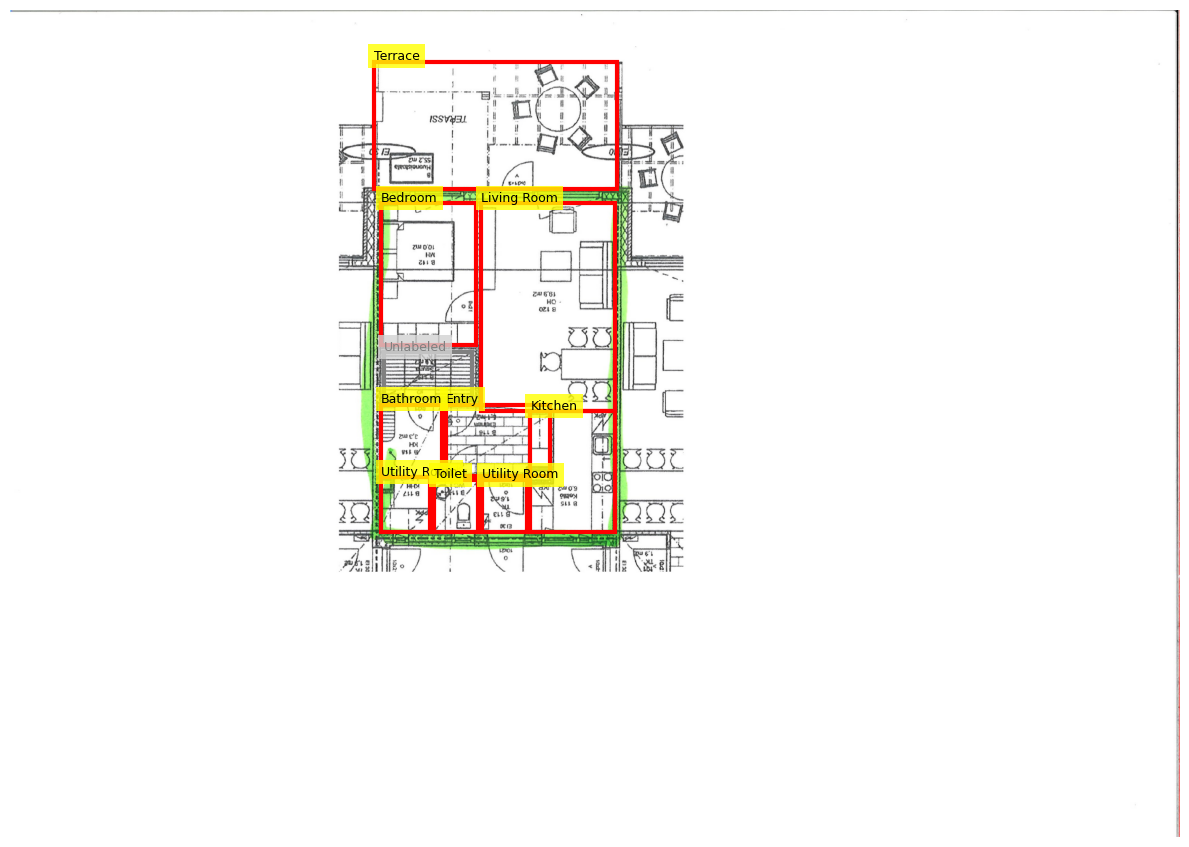

In [15]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load annotations
with open("annotations/train_annotations.json") as f:
    coco = json.load(f)

# Build image and category lookup
image_lookup = {img["id"]: img for img in coco["images"]}
category_lookup = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Visualize one image
def visualize_image(image_id, base_dir):
    img_info = image_lookup[image_id]
    img_path = os.path.join("/content/cubicasa_dataset/cubicasa5k", img_info["file_name"])

    if not os.path.exists(img_path):
        print(f" Image not found: {img_path}")
        return

    image = Image.open(img_path)
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)

    for ann in coco["annotations"]:
        if ann["image_id"] != image_id:
            continue

        x, y, w, h = ann["bbox"]
        label = category_lookup.get(ann["category_id"], "Unlabeled")

        # Thicker box lines
        edge_color = 'red' if label != "Unlabeled" else 'gray'
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=edge_color, facecolor='none')
        ax.add_patch(rect)

        #  Label background
        text_color = 'black' if label != "Unlabeled" else 'gray'
        bg_color = 'yellow' if label != "Unlabeled" else 'lightgray'
        ax.text(x, y - 5, label,
                fontsize=9,
                color=text_color,
                bbox=dict(facecolor=bg_color, alpha=0.8, edgecolor='none'))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
if coco["images"]:
    first_image_id = coco["images"][0]["id"]
    visualize_image(first_image_id, "/content/cubicasa_dataset/cubicasa5k")
else:
    print("No images found in the annotations.")

In [16]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))


In [19]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os
# Removed redundant imports and dataset registration

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cpu"

cfg.DATASETS.TRAIN = ("cubicasa_train",)
cfg.DATASETS.TEST = ("cubicasa_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.OUTPUT_DIR = "/content/drive/MyDrive/cubicasa_checkpoints"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []  # No LR decay
cfg.SOLVER.CHECKPOINT_PERIOD = 100  # Save every 1000 iterations

# Add gradient clipping
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "value"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0


# Update the number of classes using the length of the category_map after filtering
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_map)  # Your room types


trainer = DefaultTrainer(cfg)
# Manually build optimizer with clipping - not needed with DefaultTrainer
# trainer.optimizer = build_optimizer(cfg, trainer.model)

trainer.resume_or_load(resume=True)
trainer.train()

[09/11 23:35:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: Attribute 'thing_classes' in the metadata of 'cubicasa_val' cannot be set to a different value!
['Alcove', 'Appliance Space', 'Attic', 'Auxiliary Kitchen', 'Balcony', 'Bar Area', 'Bathroom', 'Bathroom/Toilet/Utility Room', 'Bathroom/Utility Room', 'Bedroom', 'Bedroom/Library', 'Carpenter’s Workshop', 'Carport', 'Ceiling Height Room', 'Closet/Storage', 'Cold Storage', 'Commercial Space', 'Corridor', 'Dining', 'Dining Area', 'Dressing Room', 'Entry', 'Fenced Garden', 'Fireplace', 'Fireplace/Technical Room', 'Garage', 'Generic Room', 'Glazed Balcony', 'Glazed Balcony/Terrace', 'Glazed Porch', 'High Ceiling Space', 'Hobby Room', 'Hobby Space', 'Home Theater', 'Indoor Storage', 'Kitchen', 'Kitchenette', 'Laundry Room', 'Laundry/Washing Room', 'Living Room', 'Living Room/Lounge', 'Lobby', 'Makeup Room', 'Mirror/Cabinet', 'Office', 'Office Room', 'Office and Guest Room', 'Office/Workshop', 'Oil Burner', 'Open Kitchen', 'Outdoor Space', 'Outdoor Storage', 'Porch', 'Roof Terrace', 'Sauna', 'Shelter/Shed', 'Shower', 'Shower Room', 'Steam Room', 'Storage', 'Technical Room', 'Terrace', 'Terrace Balcony', 'Toilet', 'Toilet-Washing Room', 'Toilet/Bathroom', 'Toilet/Washing Room', 'Unlabeled', 'Utility / Dressing Room', 'Utility Room', 'Walk-in Closet', 'Washing Room', 'Wooden Patio'] != ['Alcove', 'Appliance Space', 'Attic', 'Auxiliary Kitchen', 'Balcony', 'Bathroom', 'Bathroom/Utility Room', 'Bedroom', 'Carport', 'Ceiling Height Room', 'Closet/Storage', 'Corridor', 'Dining', 'Dining Area', 'Dressing Room', 'Entry', 'Fireplace', 'Fireplace/Technical Room', 'Garage', 'Generic Room', 'Glazed Balcony/Terrace', 'High Ceiling Space', 'Hobby Space', 'Kitchen', 'Kitchenette', 'Laundry Room', 'Laundry/Washing Room', 'Living Room', 'Living Room/Lounge', 'Lobby', 'Mirror/Cabinet', 'Office', 'Open Kitchen', 'Outdoor Space', 'Porch', 'Sauna', 'Shelter/Shed', 'Shower', 'Shower Room', 'Storage', 'Technical Room', 'Terrace', 'Toilet', 'Toilet/Bathroom', 'Toilet/Washing Room', 'Unlabeled', 'Utility / Dressing Room', 'Utility Room', 'Walk-in Closet', 'Washing Room']